# **MEMAKER - INTERACTIVE MUSEUM EXPERIENCE**

*#TeamLutraLutra*

This is our proposed way of handling signal data from the user and outputting paintings recomended for him and his chosen experience.

In this case, we focused on 'Fear' (based on our dataset and ease of identification) - we are using 2 signals (ECG and GSR) and we are using KNN algorithm for determining if the painting was scary or not (for now it is a binary value, but it will be improved), and for picture recommendation we are using a Random Forest Classifier.

With our dummy datasets and certain simplifications, we have achieved relatively high accuracy of our models. It should be noted, though, that this is a proof of concept  - ideally, we would like to measure more signals; our actual datasets would be way more precise and prepared in a better way, our classifiers more complex and our code much more optimized. To maximize the accuracy of our datasets, we would use focus group testing to test our hypotheses.  

In [31]:
#Imports
import sklearn as sk
import pandas as pd
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss
from scipy.signal import iirnotch
from scipy.signal import butter
from scipy.signal import lfilter, filtfilt
from  scipy.signal import find_peaks
import more_itertools as mit
import re
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from IPython.display import display, HTML

In [32]:
#Plot Parameters
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['figure.dpi'] = 100 
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.linestyle": '--', "grid.linewidth": 0.5 })
#plt.subplots_adjust(top = 1, bottom = 0.3, wspace=1, hspace=2)

Here, we are loading our ECG and GSR dataset. Signals are already filtrered, and we are preparing them for our classifier. For now, we either have scary ('tag') or not scary pictures ('rest'). We are measuring Heart Rate and mean GST in time windows where the user was shown a certain picture. The classifier outputs which data points (HR,mean GSR) were scary or not. 

In [33]:
with open('ECG_data.pkl', 'rb') as f:
    data = pickle.load(f)

def FindSequence(syg, n):
  syg = list(syg)
  indexes = [syg.index(i) for i in syg if i >= 0.3]
  temp = [list(group) for group in mit.consecutive_groups(indexes)]
  result =  [group for group in temp if len(group) >= n]
  return result

Liczba wykrytych pików R w minucie sygnału zebranego podczas odpoczynku: 94
Liczba wykrytych pików R: 94


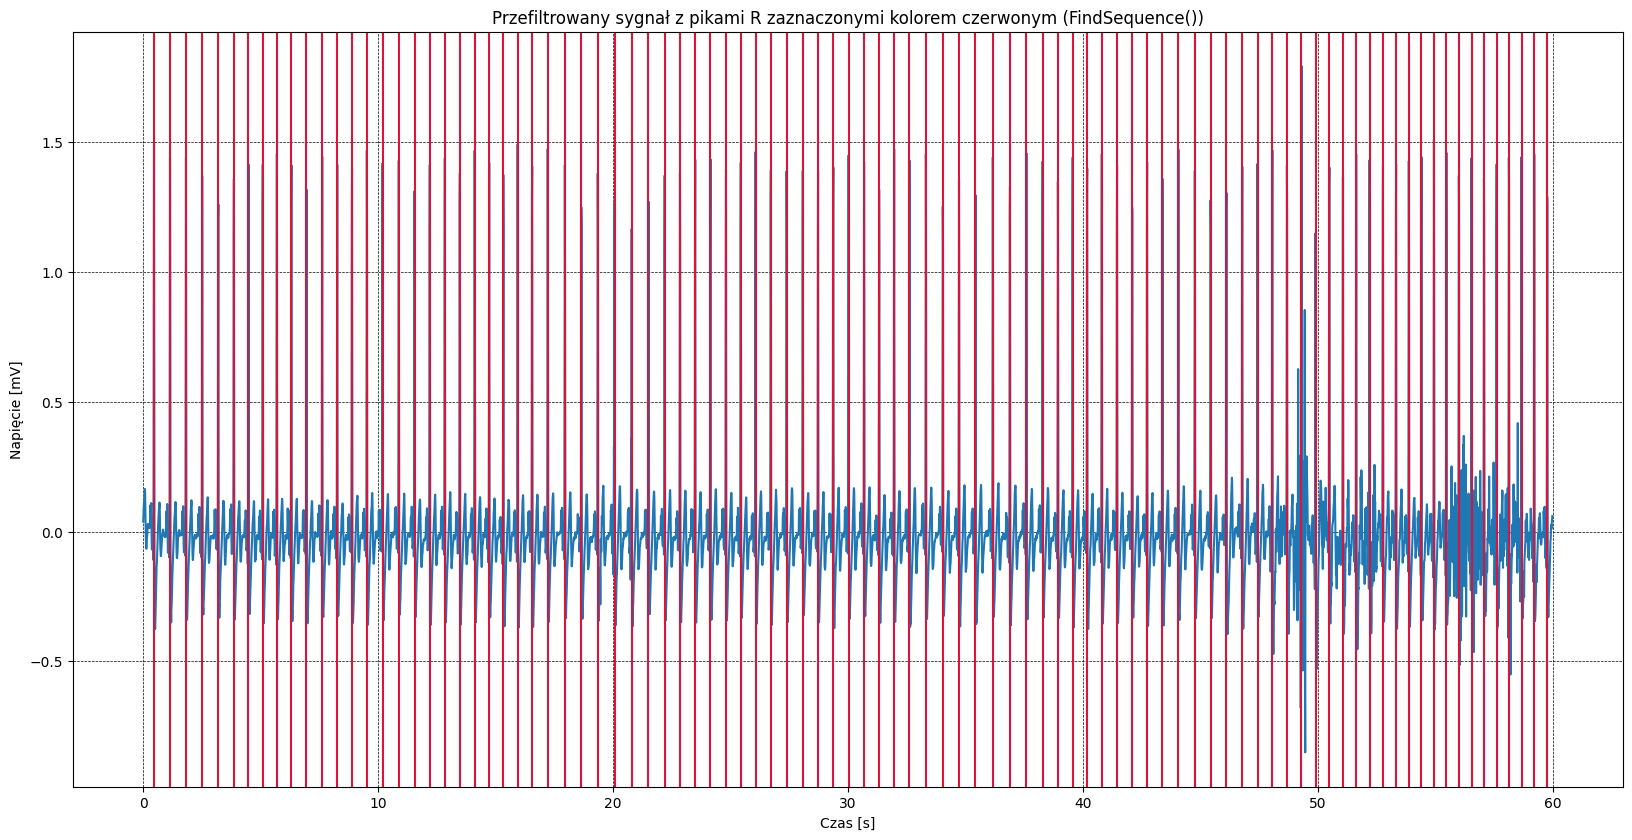

In [34]:
rest_ekg = data[0][0]
spiders_ekg = data[0][1]

Fs = 100
T = len(rest_ekg)/Fs
dt = 1/Fs
t = np.arange(0,T,dt)

min_len = 60*Fs #długość minuty
R_peaks = FindSequence(rest_ekg, 2)
print("Liczba wykrytych pików R w minucie sygnału zebranego podczas odpoczynku:",len(R_peaks))

R = FindSequence(rest_ekg, 2)
print("Liczba wykrytych pików R:",len(R))
plt.plot(t, rest_ekg)
for i in R:
    plt.axvline(x=t[i][1],ymin=-0.5,ymax=1,color="crimson")
plt.title('Przefiltrowany sygnał z pikami R zaznaczonymi kolorem czerwonym (FindSequence())')
plt.ylabel("Napięcie [mV]")
plt.xlabel('Czas [s]')
plt.grid(True)
plt.show()

Here, you can see a fragment of our code with plotted tags.

In [35]:
names = np.array(['rest', 'tag','tag','tag'])#,'tag','tag','tag'])
n = np.array(['rest', 'tag','tag','tag'])#,'tag','tag','tag'])

all_HR_tags =  np.zeros(4)
all_gsr_means =  np.zeros(4)

for i in data.keys():
  rest_ekg = data[i][0]
  fear_ekg = data[i][1]
  tags = data[i][2]
  rest_gsr = data[i][4]
  fear_gsr = data[i][5]

  Fs = 100
  dt = 1/Fs
  
  Tr = len(rest_ekg)/Fs
  tr = np.arange(0,Tr,dt)

  Tf = len(spiders_ekg)/Fs
  tf = np.arange(0,Tf,dt)

  R_peaks = FindSequence(rest_ekg, 2)
  HR_rest = len(R_peaks)/(Tr/60)

  tag = []
  Tags = []
  for item in range(len(tags)-1):
    if tags[item] == 0 and tags[item+1] != 0:
      start = item+1
    elif tags[item] != 0 and tags[item+1] == 0:
      stop = item
      Tags.append((start,stop))
  
  gsr_tags = [np.average(rest_gsr)]
  HR_tags = [HR_rest]
  for tg in Tags:
    tag_peaks = FindSequence(fear_ekg[tg[0]:tg[1]], 2)
    Tt = (tg[1]-tg[0])/Fs
    HR_tag = len(tag_peaks)/(Tt/60)
    HR_tags.append(HR_tag)
    gsr_tags.append(np.average(fear_gsr[tg[0]:tg[1]]))
  
  if len(HR_tags) >= 3 and len(gsr_tags) >= 3 and None not in gsr_tags:
    all_HR_tags = np.hstack((all_HR_tags, np.array(HR_tags[:4])))
    all_gsr_means = np.hstack((all_gsr_means, np.array(gsr_tags[:4])))
    names = np.hstack((names, n))

dataset = pd.DataFrame({
  'hr': all_HR_tags,
  'gsr': all_gsr_means,
  'name': names,
})
dataset.head()

,hr,gsr,name
0,0.0,0.000000,rest
1,0.0,0.000000,tag
2,0.0,0.000000,tag
3,0.0,0.000000,tag
4,94.0,2.794556,rest


In [36]:
display(dataset)

,hr,gsr,name
0,0.000000,0.000000,rest
1,0.000000,0.000000,tag
2,0.000000,0.000000,tag
3,0.000000,0.000000,tag
4,94.000000,2.794556,rest
...,...,...,...
227,71.815052,2.603097,tag
228,91.000000,-8.060335,rest
229,87.555337,-3.578920,tag
230,87.555337,-2.408374,tag


In [37]:
n_neighbors = 6

X=dataset[['hr', 'gsr']] 
y=dataset['name']

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4) #70% training and 30% test

#Create a Gaussian Classifier
clf = neighbors.KNeighborsClassifier(n_neighbors, weights='uniform')

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

#print(y_pred)

result = [1 if i == 'tag' else 0 for i in y_pred]
paintings = np.zeros(len(result))
for i in range(len(paintings)):
  if result[i] == 'tag':
    paintings[i] = np.random.choice([4,5,6,11,12,13,15,16,17,20,21])

print(result)
#print(paintings)

Accuracy: 0.7096774193548387
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]


Here, we are preparing a dummy presented painting dataset. It is extremely important to understand, that in the final product, this array would be made from tags registered with the signal. Here, we had no such tags available - so we prepared a simplified version. 

In [38]:
data = None
url = 'https://raw.githubusercontent.com/LLynd/Neurohackator2021TeamLutraLutra/classification_data/data.csv'
data = pd.read_csv(url)

x = data.drop('scary', axis=1)
y = data['scary']

In [39]:
#preparing data for classificator
ind = paintings#[10, 5, 9, 17, 2, 15, 19, 13, 21, 4]
val = result#[1, 0, 1, 0, 0, 0, 0, 0, 0, 0]
x_train = x
y_train = y
x_test = x
for i in range(len(data)):
  if i not in ind:
    x_train= x_train.drop(i)
    y_train = y_train.drop(i)
  else:
    x_test = x_test.drop(i)
for i in range(len(ind)):
  y_train.at[ind[i]] = val[i]

print(x_train)
print(y_train)
print(x_test)

   index  colors  humanoid  gore  animals  frame
0      0       0         1     0        0      0
0    1
Name: scary, dtype: int64
    index  colors  humanoid  gore  animals  frame
1       1       0         1     0        0      0
2       2       0         1     0        0      1
3       3       1         0     0        0      2
4       4       1         1     0        0      1
5       5       1         1     0        1      1
6       6       1         1     0        0      1
7       7       0         0     0        0      2
8       8       1         1     1        1      0
9       9       1         0     0        0      2
10     10       1         1     1        0      2
11     11       1         0     0        1      1
12     12       1         0     1        1      1
13     13       1         1     1        0      1
14     14       1         1     0        1      0
15     15       1         1     1        1      1
16     16       1         1     0        0      1
17     17       1  

In [40]:
regressor = RandomForestClassifier(n_estimators=20, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

#indexes of image that are similar to testing set
for i in range(len(y_pred)):
  if y_pred[i] == 1:
    print(x_test.iloc[i, 0])

#print("Accuracy:",metrics.accuracy_score(y_train, y_pred))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
